In [2]:
import spacy
import torch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import re
from transformers import *
from custom.transformer_sentence import TransformerSentence
from custom.chunker import Chunker
from custom.funcs import load_dataset
from fuzzywuzzy import fuzz
from tqdm import tqdm

/Users/sergicastellasape/miniconda3/envs/za_conda/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# LOAD PRETRAINED MODELS
# Scibert uncased
SciBertModel = BertModel.from_pretrained('scibert-scivocab-uncased')
SciBertTokenizer = BertTokenizer.from_pretrained('scibert-scivocab-uncased')

## Define distance metric and chunker
Chunker is the class that implements the distance based chunking. Given a sentence representation, it calculates all possible sequential chunks within it as "group candidates". For each of them calculates a centroid and if all the vectors within that chunk are below the given distance metric threshold, they're considered a valid chunk. Afterwards, chunks that are completely within other chunks are discarted, but **chunks that are only partially overlapping are not**.

In [4]:
# define similarity func.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-5)
chunker = Chunker(layer=-1, 
                  sim_function=cos, 
                  threshold=0.9, 
                  exclude_special_tokens=True, 
                  combinatorics='sequential')

In [5]:
def recall_between_lists(ground_truth, prediction, fuzzy_sim_threshold=100):
    """
    Calculates the recall that a prediction list has w.r.t a ground truth, matching them using
    fuzzy string similarity and a threshold from 0 to 100 (100 is a complete exact match). For
    reference the match between 'neural networks' and 'neural network' is 97.
    """
    recall, total = 0, 0
    for i, sentence in enumerate(ground_truth):
        for chunk in sentence:
            total += 1
            match = False
            for p in prediction[i]:
                if fuzz.ratio(chunk, p) >= fuzzy_sim_threshold: match = True
            if match: recall += 1
    return recall / total

## Load Quora Questions as the dataset

Load the test dataset from a .txt file into a list of sentences (list of strings), and list of sentence objects, which contain the contextualized BERT representations.

In [6]:
sentences, sentences_obj = load_dataset(txt_path='../datasets/quora_questions.txt',
                                       return_embeddings=False,
                                       MODEL=SciBertModel,
                                       TOKENIZER=SciBertTokenizer)

sentences = [sentence.lower() for sentence in sentences]

100%|██████████| 301/301 [00:41<00:00,  7.33it/s]


## Load spaCy language and compute noun chunks for the dataset

In [9]:
#!python -m spacy download en
# Generate the spacy noun chunks as "ground truth"!
nlp = spacy.load("en") # en_core_web_sm

spacy_noun_chunks = [] # this is gonna be a list of lists
for sentence in sentences:
    doc = nlp(sentence)
    chunks = []
    for chunk in doc.noun_chunks:
        joint_token = str(chunk).replace(' ', '_')
        
        chunks.append(joint_token)
    spacy_noun_chunks.append(chunks)

## Recall evaluation
This script below calculates chunks for a series of different similarity thresholds and evaluates the recall it has for each one with respect to the spaCy noun chunks, with a fuzzy_similarity_threshold of 95. The x-axis of the plot is the threshold. Also, it runs it using different layers from the BERT model, each one is in a different color.

Interestingly, the best performance is achieved by the last 5th layer at a threshold of 0.9. If we use the last layer, the optimal performance a little bit above 0.9. In any case, the recall doesn't exceed 60%.

### The two 'cheats'
- This implementation fo the similarity based chunking allows for overlapping chunks (which is extremely common as you can see in the examples), but is probably very sub-optimal, and a little bit like cheating for this evaluation purpose.
- This evaluation only computes recall, not precision. If you analyze the results qualitatively, you'll easily see that there are a lot of chunks that are not noun phrases, or are only part of them.

100%|██████████| 7/7 [09:50<00:00, 84.36s/it]


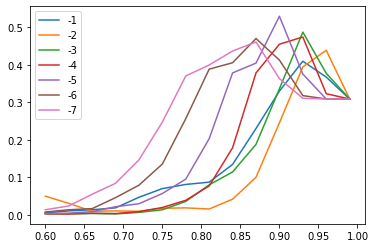

In [11]:
thrs = np.arange(0.6, 1., 0.03)
layer = list(range(-1, -8, -1))
R = []
for L in tqdm(layer):
    recalls = []
    for thr in thrs:
        tf_chunks = []
        for sentence in sentences_obj:
            _, t = chunker.compact(sentence, threshold=thr, layer=L)
            tf_chunks.append(t)
        r = recall_between_lists(spacy_noun_chunks, tf_chunks, fuzzy_sim_threshold=95)
        recalls.append(r)
    R.append(recalls)


for i, recalls in enumerate(R):
    plt.plot(thrs, recalls, label=layer[i])
plt.legend()

## How do this cosine-similarity chunks look like?
Below we can see the comparison of the first N samples from the quora questions with the original sentence, the spacy noun chunks ("ground truth"), and the distance based chunking.

In [8]:
thr, N, L = 0.90, 5, -1
tf_chunks = []
for sentence in sentences_obj:
    _, t = chunker.compact(sentence, threshold=thr, layer=L)
    tf_chunks.append(t)
    #tf_chunks = chunks_prediction_from_sentence_objects(sentences_obj, thr=thr, model_layer=-1)
for i in range((len(tf_chunks))):
    #print(sentences_obj[i].raw_string)
    #print('Spacy chunks: ', spacy_noun_chunks[i])
    #print(f'Distance-based chunks, thr={thr}:', tf_chunks[i])
    print(tf_chunks[i])


['are_convolutional', 'convolutional_neural_networks', 'networks_useful', 'useful_for', 'for_tasks', 'tasks_other', 'other_than', 'than_image', 'image_classification', 'classification_?']
['are', 'non_-_causal', 'causal_temporal_convolution', 'temporal_convolutions', 'the_equivalence', 'equivalence_of', 'bi_-', 'lstm', '?']
['are', 'there_any', 'any_techniques', ',_1', 'other_than', 'rnn', '/', 'ls', '##tm', ',_2', 'to_handle', 'handle_time', 'time_series_data', '?']
['bayesian_inference', 'inference_:', ':_what', 'what_is', 'is_a', 'a_dirichlet_process', 'process_in', 'in_lay', 'layman', "##man_'", "'_s", 's_terms', 'terms_?']
['can', 'an_objective', 'objective_account_of', 'of_statistical_inference', 'inference_be', 'be_based_on', 'frequentist', '##ist_methods', 'methods_and_bayesian', 'bayesian_methods', '?']
['can_bayesian', 'bayesian_network', 'network_be', 'be_combined_with', 'with_deep', 'deep_learning', 'learning_and', '/_or', 'reinforcement_learning', 'learning_to', 'to_figure